# Маркетинговое исследование Procrastinate Pro+

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.

Получены 3 файла данных /datasets/visits_info_short.csv,
/datasets/orders_info_short.csv,
/datasets/costs_info_short.csv, содержащие информацию о посещениях приложения, заказах и расходах на рекламу. Необходимо выполнить предобработку данных, написать функции и провести исследование которое поможет увеличить прибыль бизнеса.

# Шаг 1. Загрузите данные и подготовьте их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
visits.rename({
    'User Id':'user_id',
    'Region' :'region',
    'Device' :'device',
    'Channel':'channel',
    'Session Start': 'session_start',
    'Session End' : 'session_end'
}, axis=1, inplace=True)

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_start'])

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [6]:
orders.rename({
    'User Id':'user_id',
    'Event Dt':'event_dt',
    'Revenue':'revenue'
}, axis='columns', inplace=True)
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [8]:
costs.rename({'Channel':'channel'}, axis=1, inplace=True)
# преобразуем данные о времени
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [9]:
display(
visits.duplicated().sum(),
orders.duplicated().sum(),
costs.duplicated().sum()
)

0

0

0

Мы провели предобработку полученных датасетов, привели названия столбцов к snake_case, изменили формат данных в столбцах с датой.

# Шаг 2. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии



## get_profiles

In [10]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

## get_retention

In [11]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

## get_conversion

In [12]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

## get_ltv

In [13]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

## filter_data

In [14]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

## plot_retention

In [15]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

## plot_conversion

In [16]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## plot_ltv_roi

In [17]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Зададим параметры, создадим переменные

In [18]:
events = None
profiles = get_profiles(visits, orders, events, costs)
observation_date = profiles['dt'].max()
horizon_days = 14

# Шаг 3. Проведите исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

## Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?

Text(0.5, 0, 'Распределение покупателей по странам')

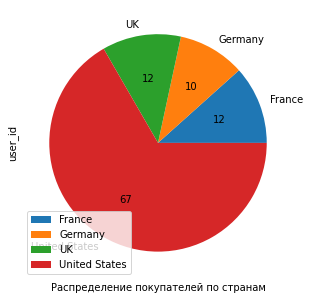

In [19]:
(profiles
.groupby('region')
.agg({'user_id':'count'})
.plot(kind='pie', subplots=True, autopct = '%.0f', figsize=(5,5)))
plt.xlabel('Распределение покупателей по странам')

In [20]:
print('Доля покупателей по странам')
(
profiles
.groupby('region')
.agg({'payer':'mean'}) #Почему я не могу сделать .agg({'payer':['mean','sum','count']})?
.sort_values(by='payer', ascending=False)
)


Доля покупателей по странам


,payer
region,
United States,0.069019
Germany,0.041119
UK,0.039829
France,0.037994


In [21]:
print('Абсолютное количество покупателей по странам')
(
profiles
.groupby('region')
.agg({'payer':'sum'}) 
.sort_values(by='payer', ascending=False)
)

Абсолютное количество покупателей по странам


,payer
region,
United States,6902
UK,700
France,663
Germany,616


## Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?

Text(0.5, 0, 'Доля устройств в продажах')

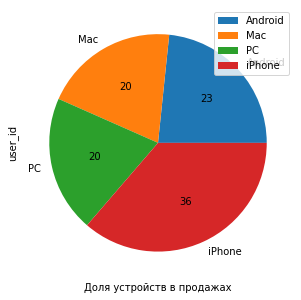

In [22]:
(profiles
.groupby('device')
.agg({'user_id':'count'})
.plot(kind='pie', subplots=True, autopct = '%.0f', figsize=(5,5)))
plt.xlabel('Доля устройств в продажах') 
#А можно вывести абсолютные значения и проценты рядом какой нибудь простой функцией?
# Например для mac 30042(20)

In [23]:
print('Доля покупателей по устройствам')
(
profiles
.groupby('device')
.agg({'payer':'mean'}) 
.sort_values(by='payer', ascending=False)
)

Доля покупателей по устройствам


,payer
device,
Mac,0.063644
iPhone,0.062079
Android,0.058518
PC,0.050468


In [24]:
print('Количество покупателей по устройствам')
(
profiles
.groupby('device')
.agg({'payer':'sum'}) 
.sort_values(by='payer', ascending=False)
)

Количество покупателей по устройствам


,payer
device,
iPhone,3382
Android,2050
Mac,1912
PC,1537


## По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

Text(0.5, 0, 'Распределение покупателей по каналам привлечения')

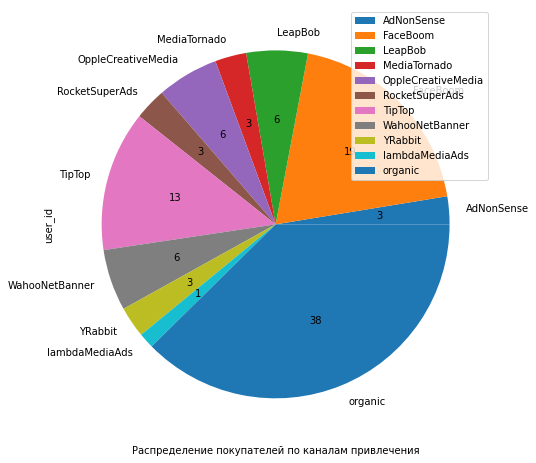

In [25]:
(profiles
.groupby('channel')
.agg({'user_id':'count'})
.plot(kind='pie', subplots=True, autopct = '%.0f', figsize=(8,8)))
plt.xlabel('Распределение покупателей по каналам привлечения')

In [26]:
print('Доля покупателей по каналам привлечения')
(
profiles
.groupby('channel')
.agg({'payer': 'mean'}) 
.sort_values(by='payer', ascending=False)
)

Доля покупателей по каналам привлечения


,payer
channel,
FaceBoom,0.122049
AdNonSense,0.113402
lambdaMediaAds,0.104700
TipTop,0.096007
RocketSuperAds,0.079137
WahooNetBanner,0.052964
YRabbit,0.038265
MediaTornado,0.035747
LeapBob,0.030633


In [27]:
print('Абсолютное количество привлеченных по источникам')
(
profiles
.groupby('channel')
.agg({'payer': 'sum'}) 
.sort_values(by='payer', ascending=False)
)

Абсолютное количество привлеченных по источникам


,payer
channel,
FaceBoom,3557
TipTop,1878
organic,1160
WahooNetBanner,453
AdNonSense,440
RocketSuperAds,352
LeapBob,262
OppleCreativeMedia,233
lambdaMediaAds,225


In [28]:
display(
profiles['dt'].min(),
profiles['dt'].max()
)

datetime.date(2019, 5, 1)

datetime.date(2019, 10, 27)

Наибольшее количество пользователей пришло 28 сентября 2019 года, наимешьнее - 17 июля 2019 года.

## Вывод

67% пользователей приходят из США. Пользователи заходят с устройств android, pc, mac, iphone примерно в равных долях. FaceBoom,
AdNonSense и 
lambdaMediaAds приносят в сумме больше 33% пользователей, органический трафик приносит ~2%.

# Шаг 4. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

## Сколько денег потратили? Всего / на каждый источник / по времени

In [29]:
profiles = profiles.query('channel != "organic"')

In [30]:
sum_costs = costs['costs'].sum()
print('Всего потратили на рекламу')
sum_costs

Всего потратили на рекламу


105497.30000000002

In [31]:
print('Из них:')
t = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
t['percentage'] = round(t['costs'] / sum_costs * 100, 2)
t

Из них:


,costs,percentage
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


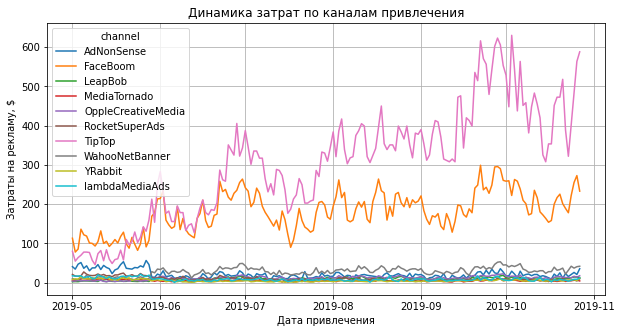

In [32]:
costs.pivot_table(
    index='dt', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('Затраты на рекламу, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика затрат по каналам привлечения')
plt.show()

In [33]:
cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values(by='cac', ascending=False)
)

cac

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


У TipTop самый большой CAC и самая большая доля расходов среди всех источников трафика. Посмотрим в каких странах TipTop наиболее активен.

In [34]:
profiles.query('channel == "TipTop"').groupby('region').agg({'user_id':'count'})

,user_id
region,
United States,19561


Только Соединенные Штаты!

In [35]:
print('Средняя CAC за весь период, для всех источников')
display(profiles['acquisition_cost'].mean(),
profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by='acquisition_cost', ascending=False))

Средняя CAC за весь период, для всех источников


1.1274813239427588

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


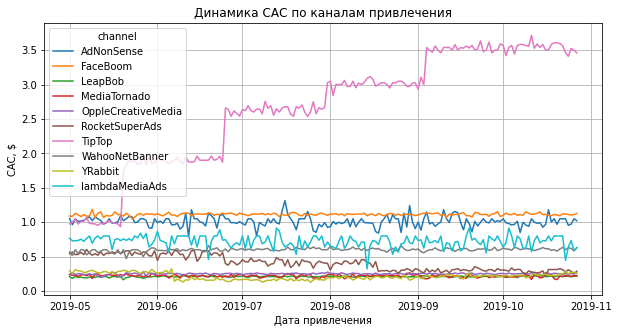

In [36]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Похоже что проблема с источником трафика TipTop, он съедает больше половины расходов на рекламу, но дает ли соответствующий ROI?

# Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

Проанализируйте общую окупаемость рекламы

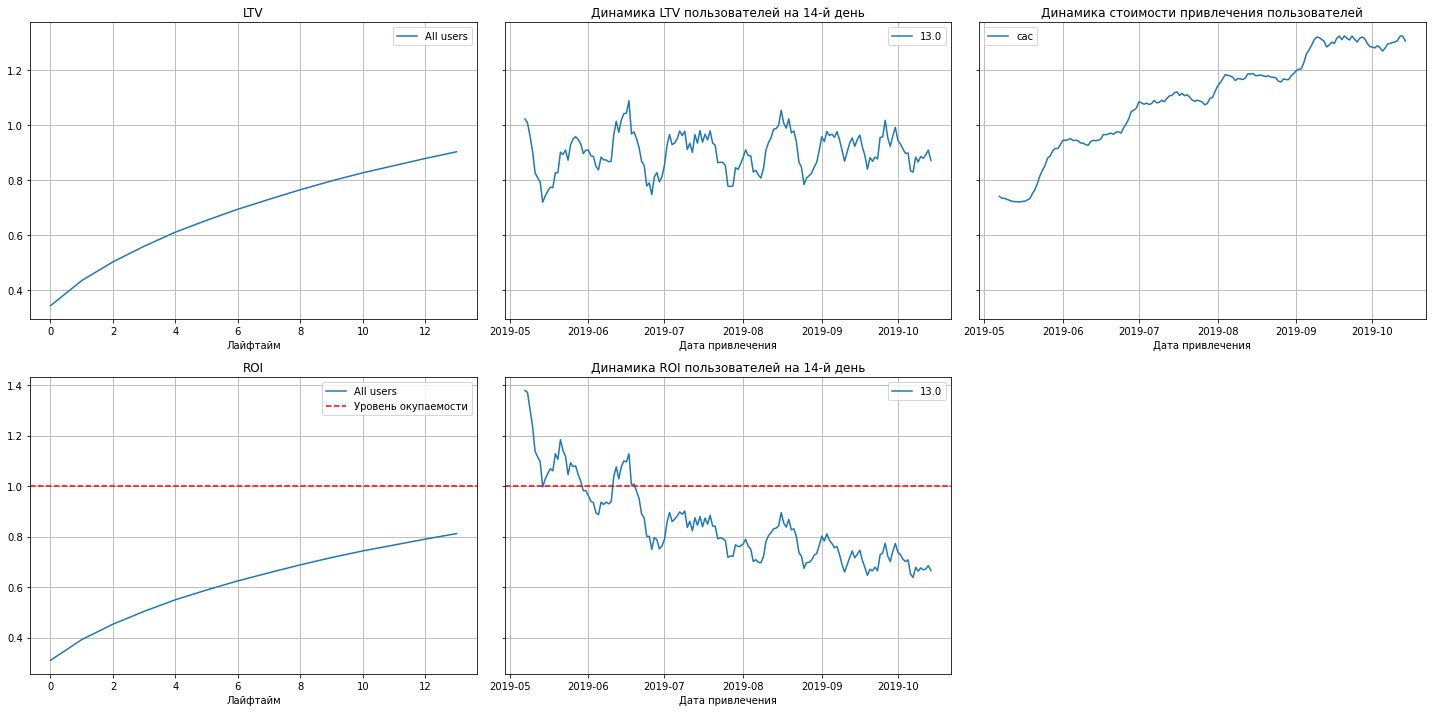

In [37]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Реклама не окупается, ROI ~0.8 на 13й лайфтайм и продолжает падать, а стоимость привлечения пользователей - расти.

Проанализируйте окупаемость рекламы с разбивкой по устройствам

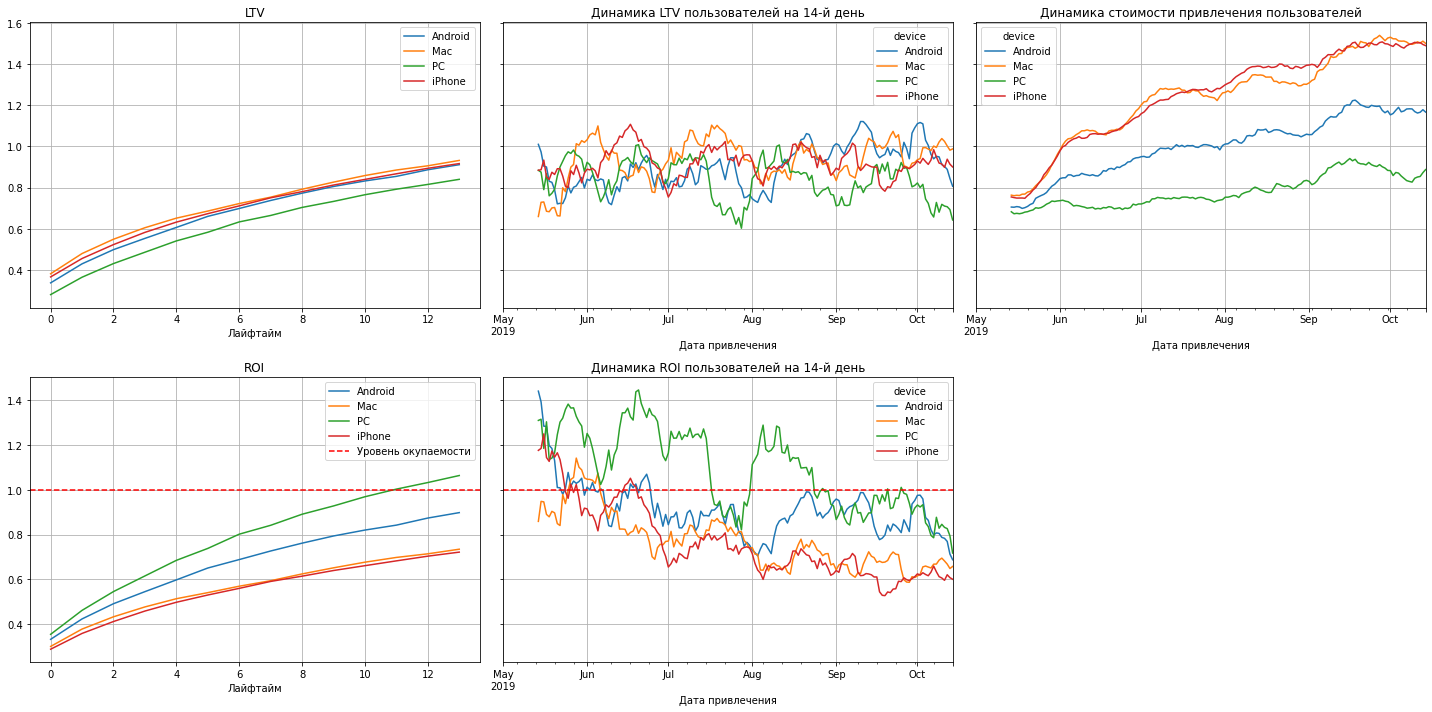

In [38]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Все устройства показывают примерно одинаковую динамику, PC показывает наилучшие показатели, продукция Apple - наихудшие.

Проанализируйте окупаемость рекламы с разбивкой по странам

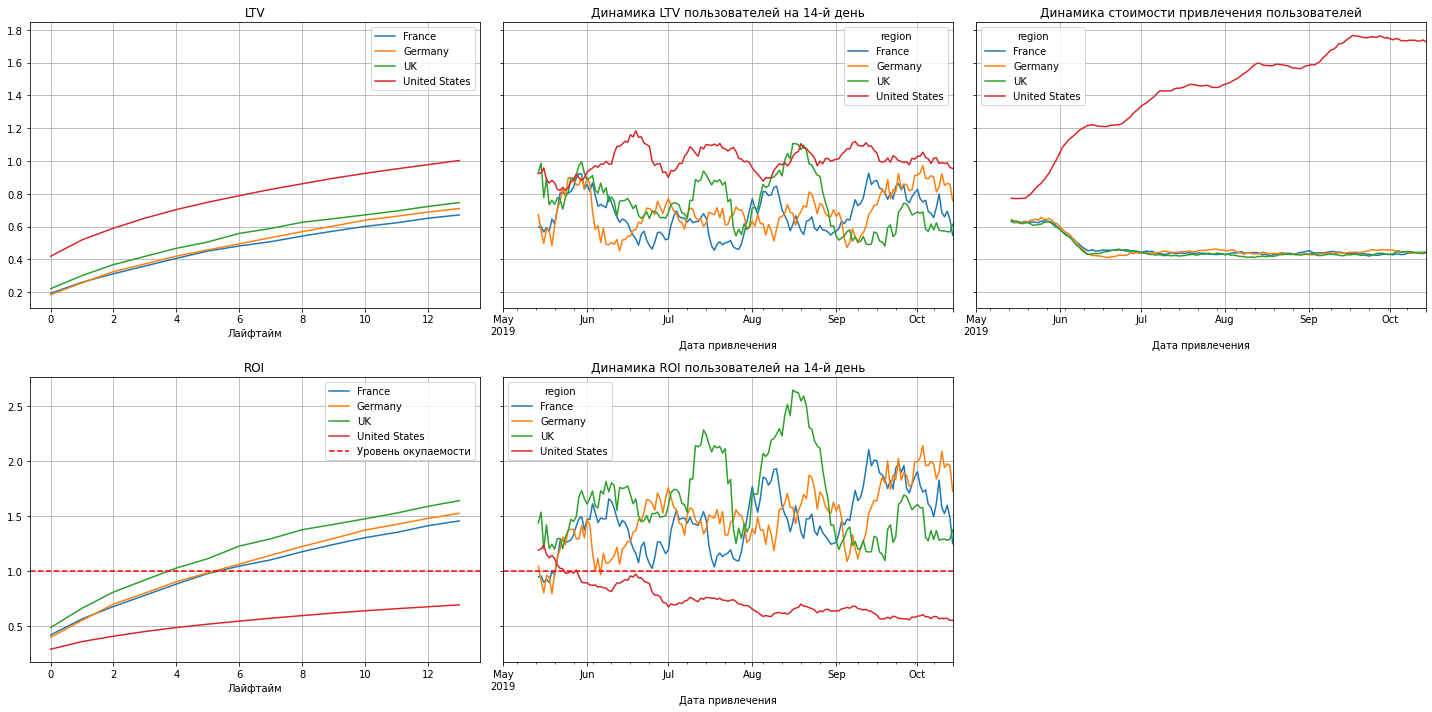

In [39]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

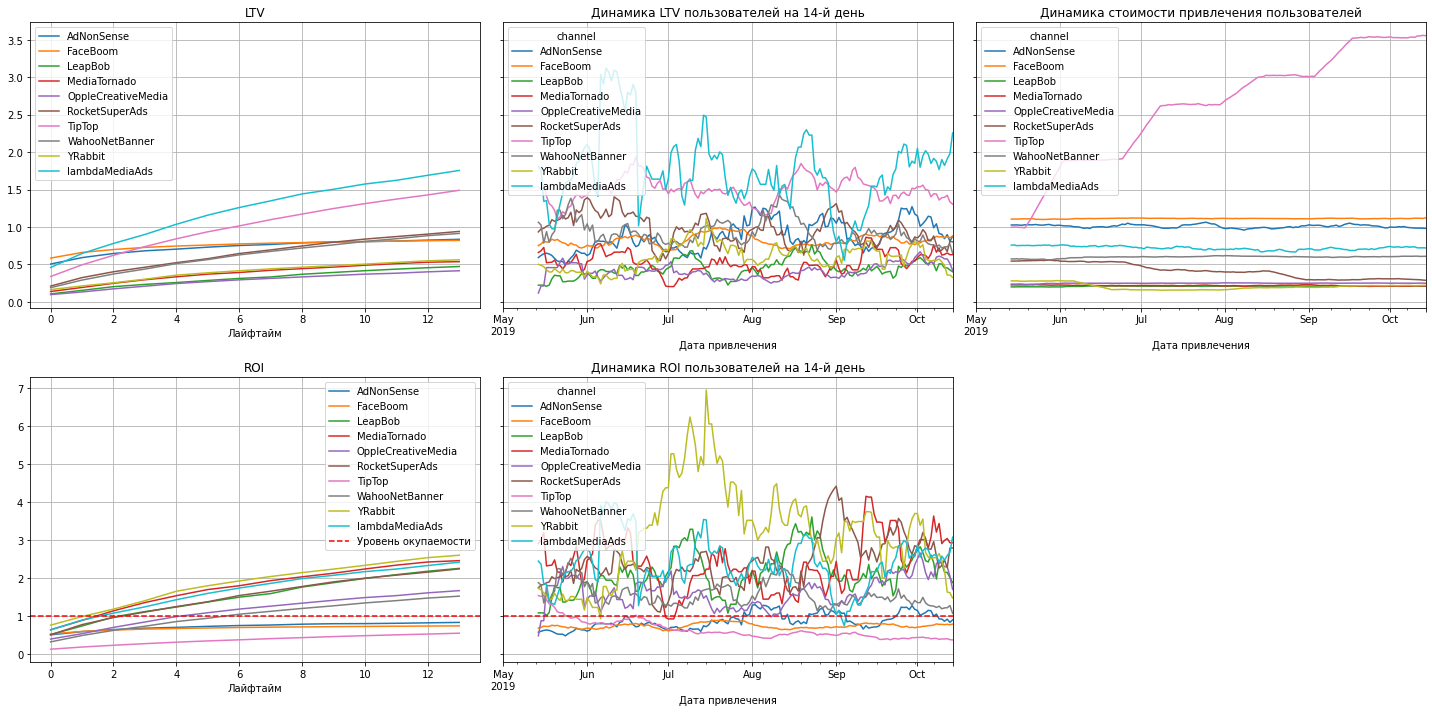

In [40]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

FaceBoom, TipTop и AdNonSense не окупаются, YRabbit выглядит наиболее преспективно из всех источников трафика.

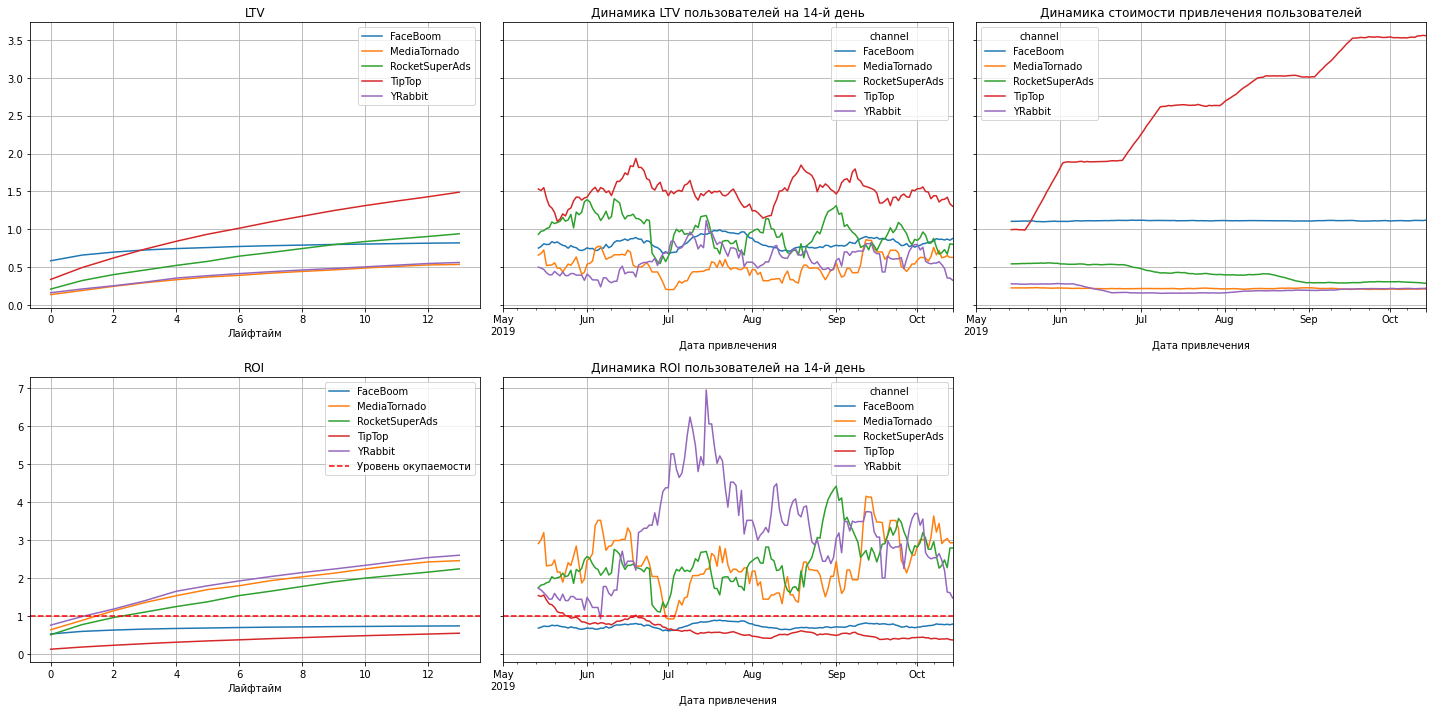

In [41]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region == "United States"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Стоимость привлечения пользователей в США резко выросла в июне, но резко упала в других регионах! LTV в штатах чуть выше чем в других регионах. Это связано с поставщиками трафика TipTop и FaceBoom. Во всех регионах кроме Штатов, компания выходит в плюс на 4-6 день лайфтайма. В Штатах - не выходит даже на 14й. Остальные поставщики трафика показывают схожую динамику, явного фаворита нет.

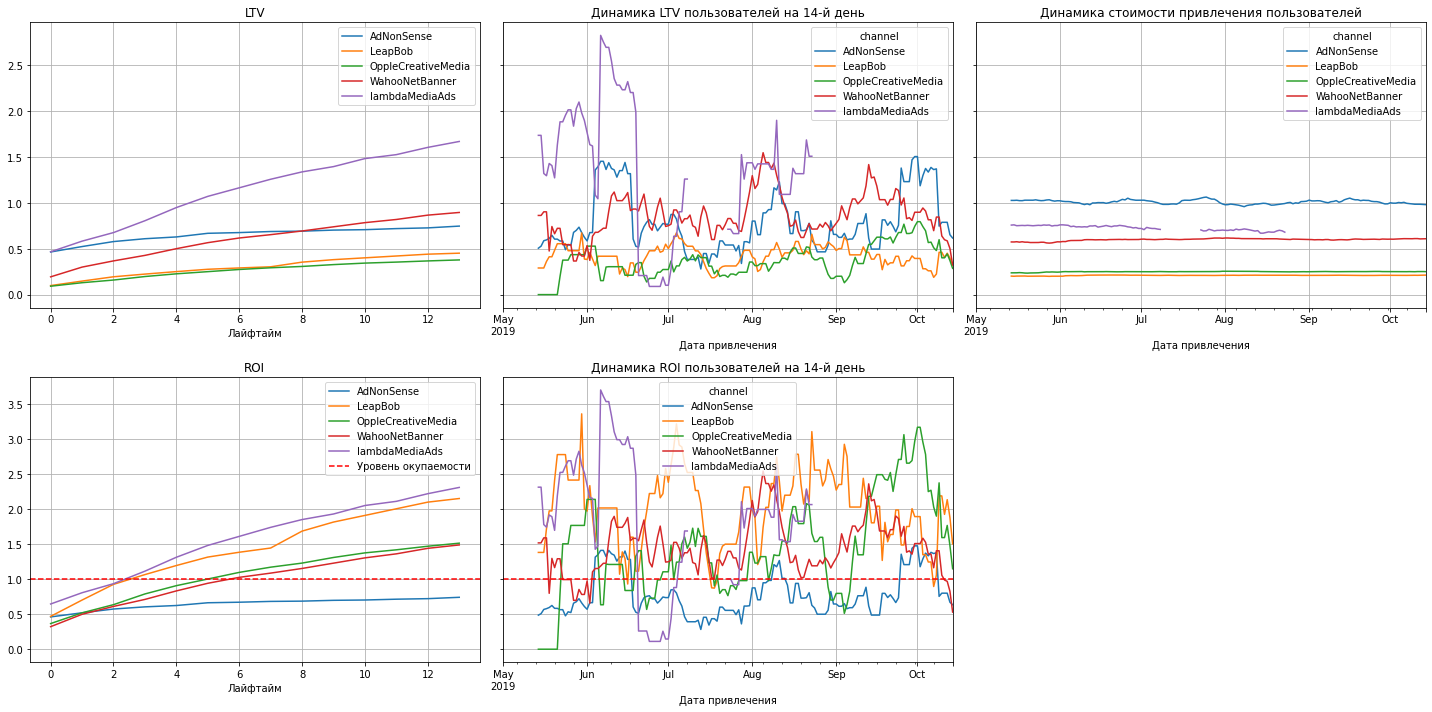

In [42]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region == "France"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Во Франции проседает AdNonsense, а самые быстро окупающиеся источники трафика LambdaMediaAds и LeapBob.

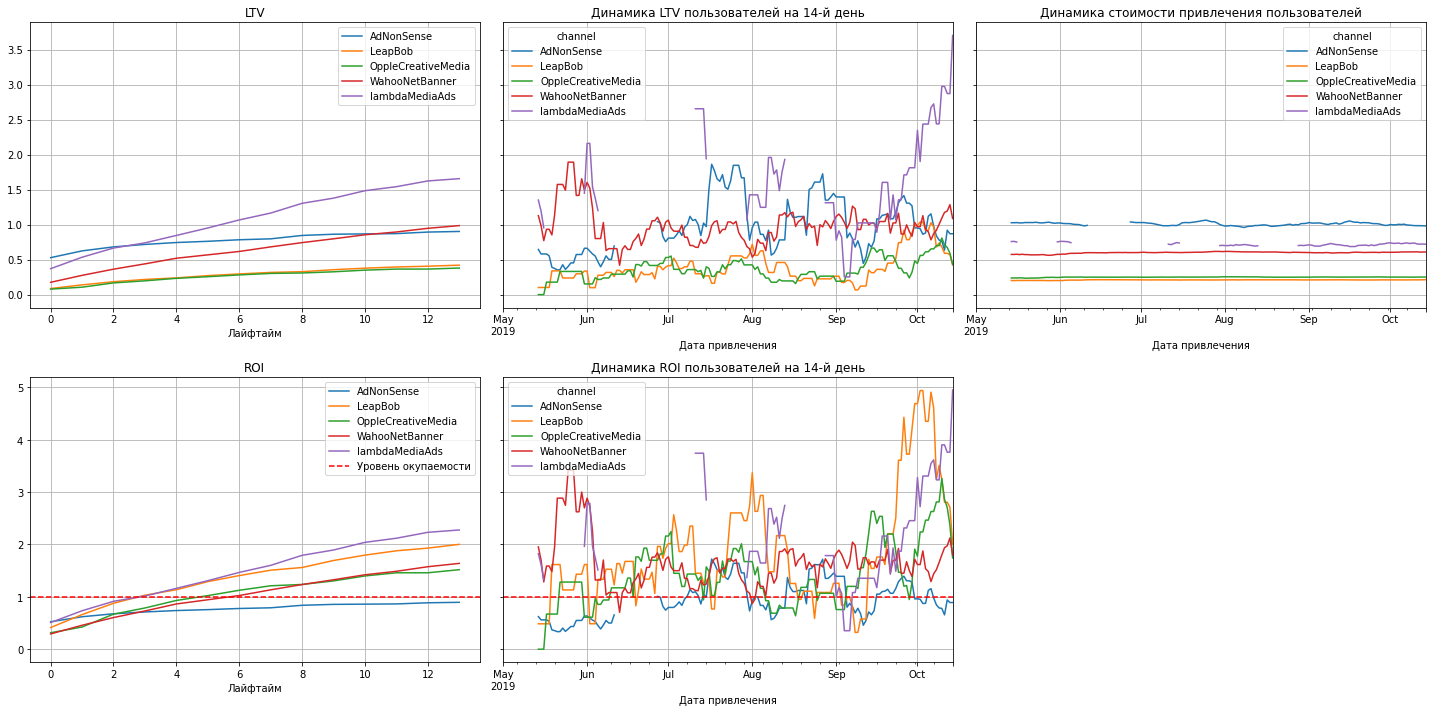

In [43]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region == "Germany"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Та же картина что и для Франции.

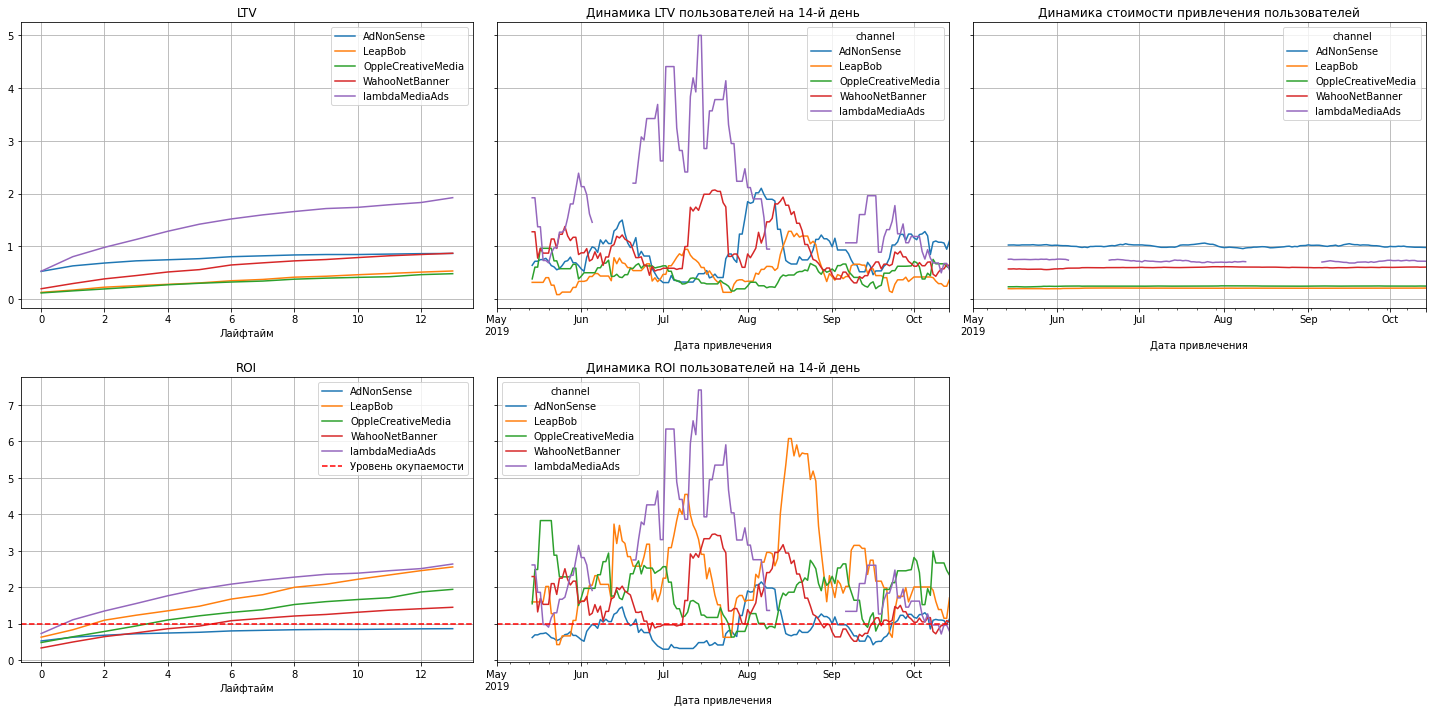

In [44]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region == "UK"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

И в Англии тоже AdNonSense самый слабый.

Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

Несмотря на приемлемую CAC, FaceBoom и AdNonSense не окупаются изза низкого LTV пользователей. У TipTop же попросту слишком дорогой трафик.

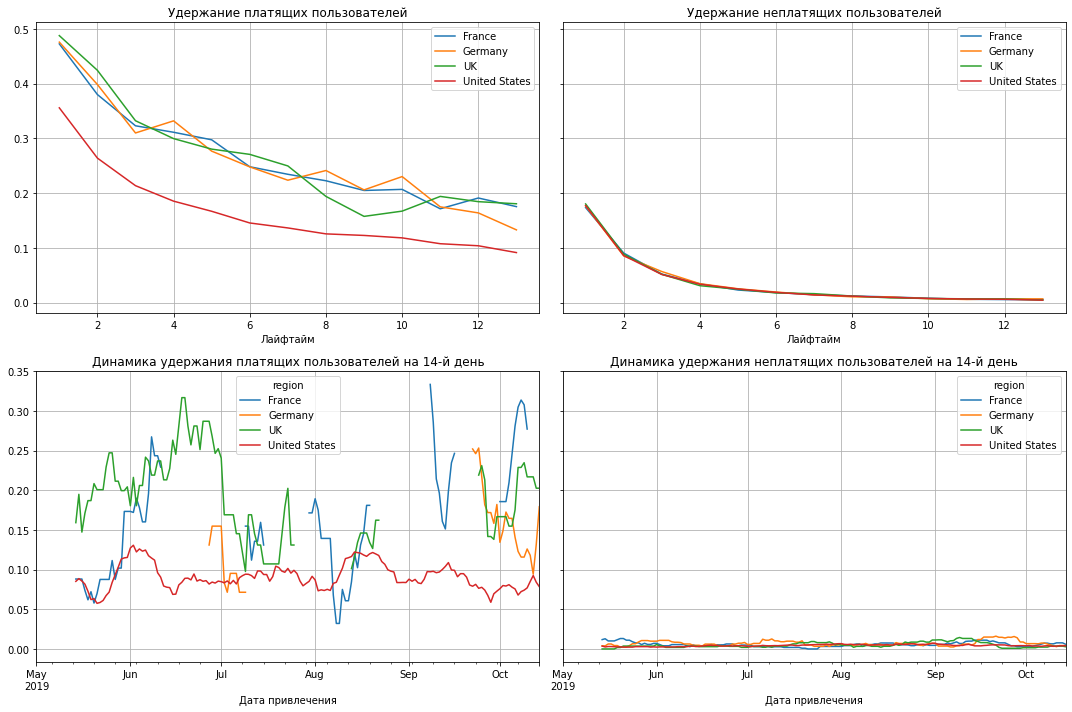

In [45]:
retention_raw, retention, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions=['region'])
plot_retention(retention, retention_history, 14, window=14)

США сильно проседает по удержанию платящих пользователей.

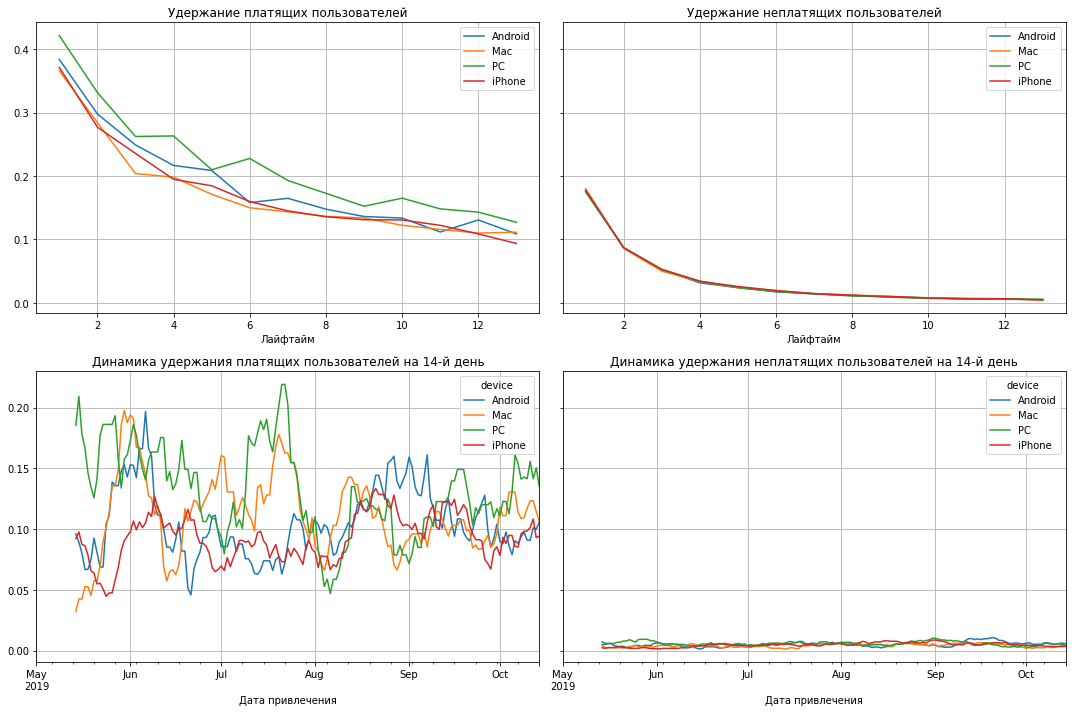

In [46]:
retention_raw, retention, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions=['device'])
plot_retention(retention, retention_history, 14, window=14)

Удержание по устройствам пркатически одинаковое.

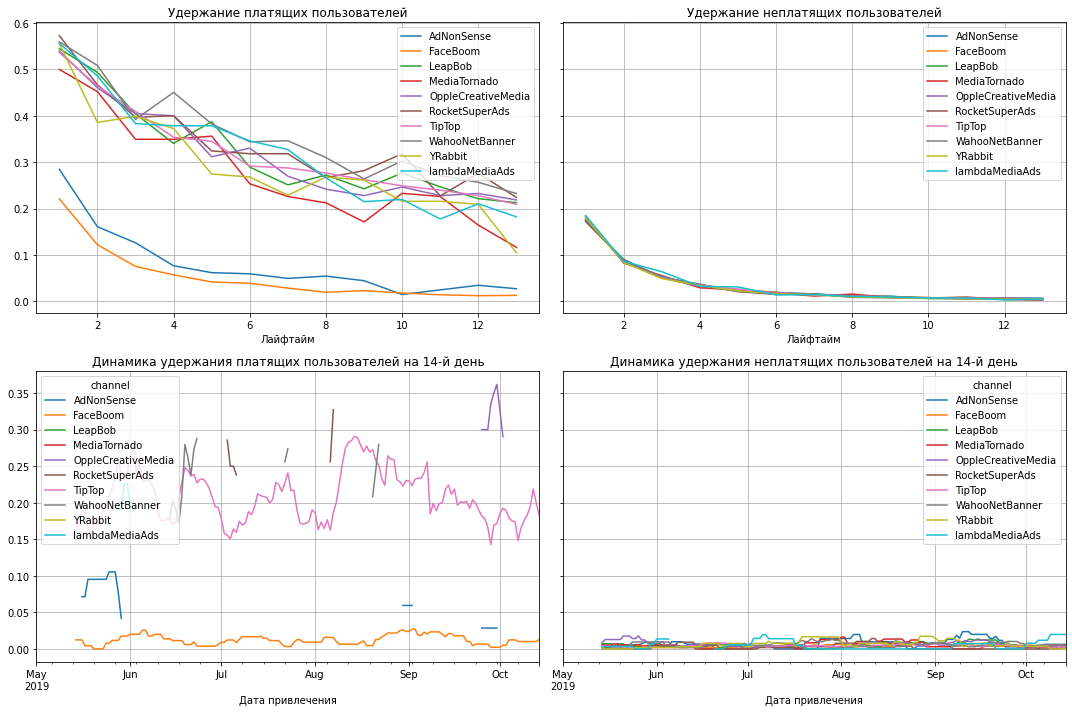

In [47]:
retention_raw, retention, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions=['channel'])
plot_retention(retention, retention_history, 14, window=14)

AdNonSense и FaceBoom сильно проседают по удержанию.

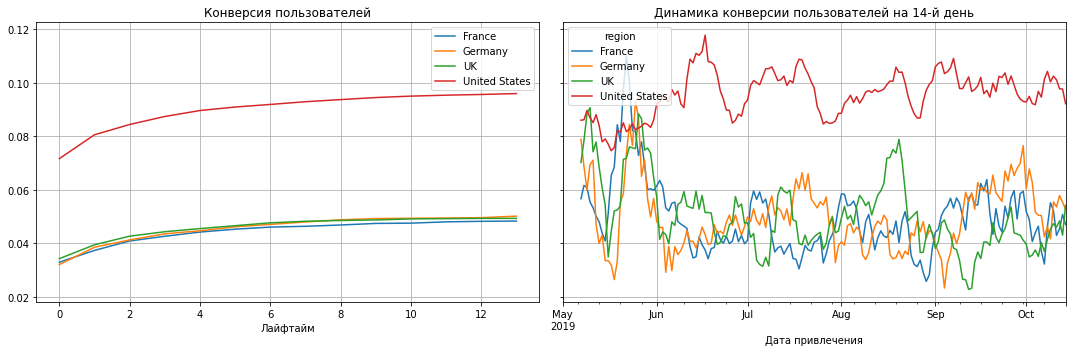

In [48]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['region']
)
plot_conversion(conversion, conversion_history, horizon_days, window=7)

В США отличная конверсия, но это все равно не покрывает расходы на рекламу.

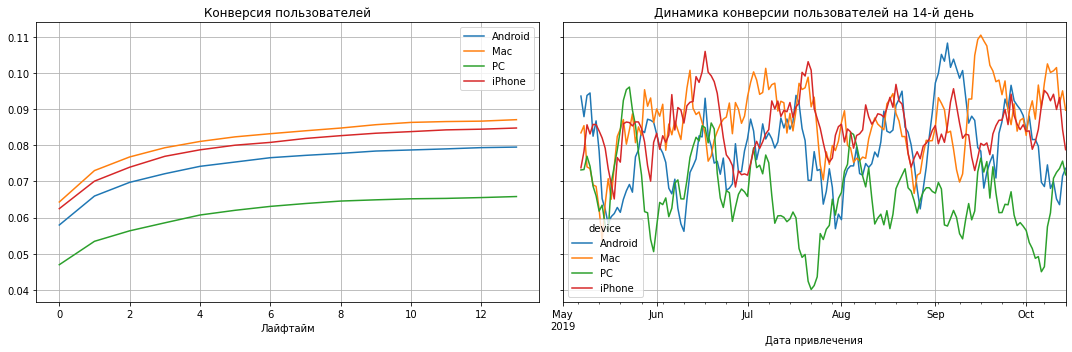

In [49]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['device']
)
plot_conversion(conversion, conversion_history, horizon_days, window=7)

У всех устройств конверсия примерно одинакова, у PC чуть хуже чем у остальных устройств.

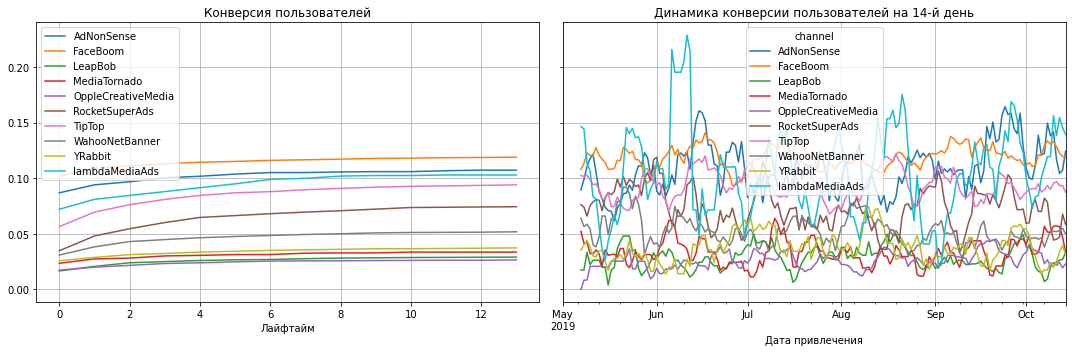

In [50]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel']
)
plot_conversion(conversion, conversion_history, horizon_days, window=7)

## Вывод

В результате проведенного исследования были выявлены проблемные источники трафика, которые не выходят на окупаемость. Значительных различий в качестве пользователей между устройствами и странами не обнаружено. PC окупается лучше чем другие устройства. В Америке хорошая конверсия, но Штаты проседают по ROI. Удержание платящих пользователей с Faceboom и AdNonSense значительно хуже чем из других источников.

# Шаг 6. Напишите выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

Мы провели анализ окупаемости рекламы и выявили следующие проблемы. Некоторые источники трафика не окупаются, в частности TipTop, FaceBoom в США и AdNonSense в Европе. Если исключить их из корзины наших источников трафик, мы будем выходить на окупаемость уже на 3й лайфтайм.

Другое решение - потребовать от этих источников снизить цену трафика, чтобы они вышли на окупаемость.

Также стоит обратить внимание на прибыль от устройств. PC показывает самые лучше результаты, остальные девайсы недотягивают. Возможно проблема в том, что приложения на этих устройствах работают хуже?

У FaceBoom и TipTop очень маленькое удержание пользователей. Вероятно рекламу показывают всем подряд, и люди не заинтересованы в продукте либо существует 

В США стоит обратить внимание на источники трафика MediaTornado, RocketSuperAds и YRabbit.

В Европе стоит обратить внимание на источники трафика LeapBob, OppleCreativeMedia, WahooNetBanner и LambdaMediaAds.

In [51]:
new_profiles = profiles.query('(channel != "FaceBoom") & (channel != "TipTop") & (channel != "AdNonSense")')

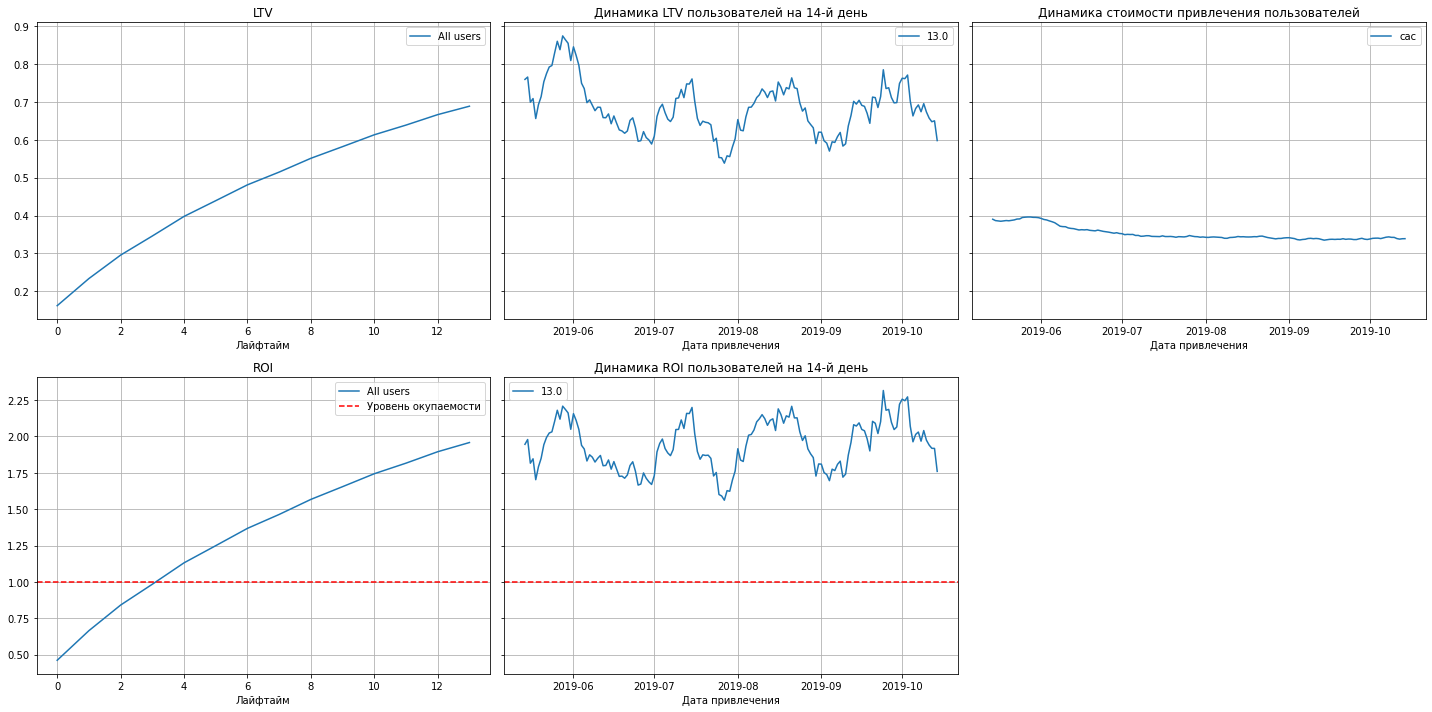

In [52]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    new_profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)